In [1]:
import pandas as pd
import re
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler

In [2]:
import torch
import torch_directml  # Correct way to use DirectML with PyTorch

# Initialize DirectML device
device = torch_directml.device()
print(f"Using device: {device}")

# Test tensor on GPU
tensor = torch.ones(5, device=device)
print(tensor)

Using device: privateuseone:0
tensor([1., 1., 1., 1., 1.], device='privateuseone:0')


In [3]:
# Load the data
drive_path = "C:/ML/separated_postings.csv"
df = pd.read_csv(drive_path, engine="python", on_bad_lines='skip')

In [4]:
# Preprocess the text data
def preprocess(text):
    text = re.sub(r'\W+', ' ', str(text).lower())  # Remove special characters and lowercase
    return text


In [5]:
df['clean_text'] = df.iloc[:, 0].dropna().apply(preprocess)  # Assuming job postings are in the first column
vectorizer = CountVectorizer(max_df=0.9, min_df=10, stop_words='english')
text_matrix = vectorizer.fit_transform(df['clean_text'].dropna())

In [6]:
# Fit LDA model
num_topics = 10  # Adjust based on your data
lda_model = LDA(n_components=num_topics, random_state=42)
lda_matrix = lda_model.fit_transform(text_matrix)


In [41]:
# Display the topics with top words
def display_topics(model, feature_names, num_top_words=100):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[-num_top_words:]]))

In [42]:
display_topics(lda_model, vectorizer.get_feature_names_out())


Topic 1:
technology executive provide career looking driven formatted_experience_level leadership zip_code passion manage brands self fast learn day excellent learning selling world grow results speciality strategies client join business_development building strategy ensure responsibilities vision paid lead events com clients years culture performance training needs help job full_time key service make social based benefits working creative position goals store teams develop account best ll high opportunity level support build create digital content people communication management drive relationships success retail products development brand market environment media manager opportunities strong including growth customers ability role product company new skills business customer work marketing team sales

Topic 2:
account value full_time program impact offer build required identity color bank related programs level internal degree applicable ll service veteran origin religion compliance

In [62]:
from sklearn.decomposition import LatentDirichletAllocation as LDA, TruncatedSVD

# Apply Truncated SVD 
svd = TruncatedSVD(n_components=2, random_state=42)
lda_svd = svd.fit_transform(lda_matrix)  # Reduces LDA topics to 2D

In [63]:
# Compute dominant topics for each document
dominant_topics = lda_matrix.argmax(axis=1)

In [64]:
feature_names = vectorizer.get_feature_names_out()


In [65]:
word_topic_assignments = lda_model.components_.argmax(axis=0)


In [66]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import colorsys

In [67]:
topic_colors = cm.get_cmap('tab10', num_topics)  # Adjust based on number of topics

C:\Users\nicole\AppData\Local\Temp\ipykernel_12952\4227479930.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  topic_colors = cm.get_cmap('tab10', num_topics)  # Adjust based on number of topics


In [68]:
# Function to lighten colors for better readability
def lighten_color(rgb_color, factor=1.6):
    """Lightens an RGB color for better contrast."""
    h, l, s = colorsys.rgb_to_hls(*rgb_color[:3])
    l = min(1, l * factor)
    return colorsys.hls_to_rgb(h, l, s)

In [69]:
# Compute dominant topics and centroids
dominant_topics = lda_matrix.argmax(axis=1)
topic_centroids = {}
for topic_id in range(num_topics):
    topic_points = lda_svd[dominant_topics == topic_id]
    centroid = topic_points.mean(axis=0) if len(topic_points) > 0 else (0, 0)
    topic_centroids[topic_id] = centroid

In [70]:
# Function to annotate words at their dominant topic's centroid
def annotate_words_lda(word_list, vectorizer, lda_model, topic_centroids):
    feature_names = vectorizer.get_feature_names_out()
    for word in word_list:
        if word in feature_names:
            word_idx = list(feature_names).index(word)
            dominant_topic = lda_model.components_[:, word_idx].argmax()
            x, y = topic_centroids[dominant_topic]
            plt.annotate(
                word, (x, y), 
                fontsize=12, ha='center', color='black',  # Make text BLACK
            )


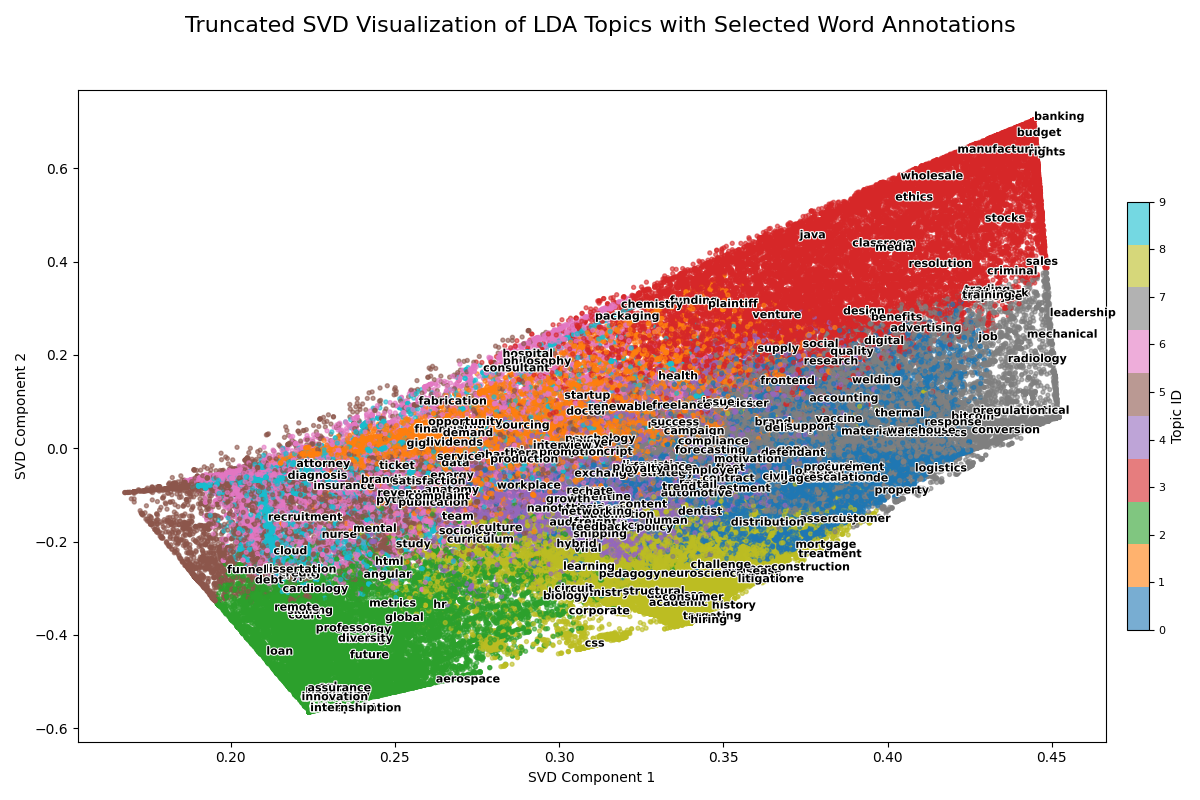

In [71]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

# Create a single plot with a reduced figure size for VSCode output cell
fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle('Truncated SVD Visualization of LDA Topics with Selected Word Annotations', fontsize=16)

# Scatter plot with topic colors
scatter = ax.scatter(
    lda_svd[:, 0], 
    lda_svd[:, 1], 
    c=dominant_topics, 
    cmap='tab10', 
    s=8, 
    alpha=0.6
)

selected_words = [
    # Tech & Programming
    'python', 'java', 'javascript', 'c++', 'html', 'css', 'react', 'angular', 'node',
    'backend', 'frontend', 'machine', 'learning', 'data', 'cloud', 'aws', 'docker',
    'devops', 'database', 'sql', 'nosql', 'api', 'tensorflow', 'pytorch', 'nlp', 'ai',
    'robotics', 'cybersecurity', 'blockchain',

    # Medicine & Healthcare
    'doctor', 'nurse', 'hospital', 'pharmacy', 'surgeon', 'treatment', 'diagnosis',
    'vaccine', 'covid', 'disease', 'therapy', 'biotech', 'gene', 'neuroscience',
    'cardiology', 'radiology', 'oncology', 'anatomy', 'dentist', 'psychology',
    'mental', 'health', 'nursing', 'pharmaceutical', 'medication', 'biology',
    'biochemistry',

    # Finance & Business
    'banking', 'investment', 'stocks', 'trading', 'bitcoin', 'crypto', 'insurance',
    'loan', 'mortgage', 'accounting', 'audit', 'financial', 'tax', 'economics',
    'revenue', 'profit', 'loss', 'funding', 'venture', 'capital', 'fintech', 'payroll',
    'dividends', 'budget', 'credit', 'debt', 'interest', 'exchange',

    # Engineering & Manufacturing
    'mechanical', 'electrical', 'civil', 'aerospace', 'automotive', 'robotics',
    'circuit', 'design', 'blueprint', 'CAD', 'manufacturing', 'production',
    'materials', 'welding', 'construction', 'structural', 'infrastructure', 'thermal',
    'hydraulics', 'renewable', 'energy', 'nanotechnology', 'automation', 'assembly',
    'fabrication',

    # Education & Research
    'university', 'professor', 'research', 'academic', 'study', 'publication',
    'dissertation', 'mathematics', 'physics', 'chemistry', 'biology', 'history',
    'philosophy', 'sociology', 'linguistics', 'pedagogy', 'learning', 'teacher',
    'classroom', 'curriculum', 'literature', 'thesis',

    # Marketing & Advertising
    'brand', 'social', 'media', 'advertising', 'seo', 'digital', 'campaign', 'content',
    'strategy', 'promotion', 'ecommerce', 'copywriting', 'conversion', 'metrics',
    'branding', 'sales', 'consumer', 'analytics', 'PR', 'engagement', 'funnel', 'viral',
    'influencer', 'targeting',

    # Legal & Compliance
    'lawyer', 'court', 'legal', 'contract', 'regulation', 'policy', 'compliance',
    'ethics', 'litigation', 'intellectual', 'property', 'corporate', 'patent',
    'trademark', 'criminal', 'civil', 'human', 'rights', 'attorney', 'defendant',
    'plaintiff',

    # Logistics & Supply Chain
    'logistics', 'supply', 'warehouse', 'inventory', 'distribution', 'transportation',
    'freight', 'shipping', 'retail', 'wholesale', 'procurement', 'packaging', 'global',
    'sourcing', 'costing', 'demand', 'forecasting', 'delivery', 'fleet', 'automation',

    # Human Resources & Recruitment
    'recruitment', 'hiring', 'interview', 'resume', 'job', 'career', 'employee',
    'employer', 'hr', 'training', 'leadership', 'workplace', 'team', 'benefits',
    'onboarding', 'performance', 'motivation', 'skills', 'diversity', 'culture',

    # Customer Support & Service
    'customer', 'support', 'service', 'complaint', 'resolution', 'satisfaction', 'call',
    'email', 'chat', 'feedback', 'quality', 'assurance', 'helpdesk', 'response', 'crm',
    'loyalty', 'issue', 'ticket', 'escalation',

    # General & Miscellaneous
    'remote', 'hybrid', 'full-time', 'part-time', 'internship', 'freelance', 'consultant',
    'gig', 'startup', 'corporate', 'industry', 'trend', 'innovation', 'growth', 'future',
    'success', 'challenge', 'opportunity', 'networking'
]
for word in selected_words:
    if word in vectorizer.vocabulary_:
        idx = vectorizer.vocabulary_[word]
        x, y = lda_svd[idx]
        txt = ax.text(x, y, word, fontsize=8, weight='bold', color='black')
        txt.set_path_effects([
            path_effects.Stroke(linewidth=1.5, foreground='white'), 
            path_effects.Normal()
        ])

# Labels and layout
ax.set_xlabel('SVD Component 1', fontsize=10)
ax.set_ylabel('SVD Component 2', fontsize=10)

# Colorbar with smaller size for VSCode
cbar = plt.colorbar(scatter, ax=ax, label='Topic ID', fraction=0.02, pad=0.02)
cbar.ax.tick_params(labelsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
